# Advanced Data Science for Transport Engineering for Coding the Curbs
In this Jupyter notebook we present our model we build for Coding the Curbs. The model is a XGBoost model that is optimized for one specific smartzone, namely Neude in Utrecht. It is possible to rerun the model for a different smartzone, however the parameters or not optimized for different smartzones. However, the weights will update accordingly. 

At each block of code there will be an explanation of what is happening and how the model can be changed to your liking and at the bottom of the notebook there is a low quality interface that can be integrated into the dashboard of Coding the Curbs. 

If you want to run the model you should first import all of the used libraries. This can be done by running the line below in your terminal. 

pip install -r requirements.txt

### Imports and Helper Functions

In [570]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import matplotlib.dates as mdates
import shap
import ipywidgets as widgets

from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import display, clear_output


These are some helper functions that gets or filters on the sensors, locations and date.

In [571]:
def get_sensors(location, data):
    """Assumes 'sensor' column exists with sensor IDs/names"""
    df = data[data["location name"] == location]
    return df['sensor id'].unique()
def get_locations(data):
    return data["location name"].unique()
def filter_by_location(location, data):
    return data[data['location name'] == location]
def filter_by_sensors(sensor, data):
    return data[data['sensor id'] == sensor]
def filter_by_date(data, date):
    '''
    start_date, end_date should be 'YYYY-MM-DD' strings or datetime
    '''
    
    start_date = pd.to_datetime(date)
    end_date = start_date
    # end_date = start_date + timedelta(days = 6)
    return data[(data["date"].dt.date >= start_date.date()) &
                (data["date"].dt.date <= end_date.date())]

These helper functions create datasets depending on the amount of sensors there are in a specific smartzone.

In [572]:
def get_data_multiple_sensors(sensors, dataset):  
    results = {}
    for sensor in sensors:
        data = filter_by_sensors(sensor, dataset).copy()
        data['status'] = data['status'].astype(int)
        data = data.sort_values('date')
        data = data.drop_duplicates(subset='date', keep='first')
        data = data.set_index('date').resample('15min').ffill().reset_index()
        data['day_of_week'] = data['date'].dt.dayofweek
        data['slot'] = data['date'].dt.hour * 4 + data['date'].dt.minute // 15
        results[sensor] = data

    return results

def get_merged_df(dataset_sensors):
    merge_dfs = []
    for sensor_id, df_sensor in dataset_sensors.items():
        df_temp = df_sensor[['date', 'status', 'slot']].copy()
        df_temp = df_temp.rename(columns={'status': f'sensor_{sensor_id}'})
        merge_dfs.append(df_temp)
    merged_df = merge_dfs[0]
    for df_next in merge_dfs[1:]:
        merged_df = pd.merge(merged_df, df_next, on=['date', 'slot'], how='outer')
    # Fill in na
    merged_df = merged_df.sort_values('date').ffill().fillna(False)
    # Calculate occupancy
    sensor_cols = [col for col in merged_df.columns if col.startswith('sensor_')]
    merged_df[sensor_cols] = merged_df[sensor_cols].astype(int)
    merged_df['status'] = merged_df[sensor_cols].sum(axis=1) / len(sensor_cols)
    
    return merged_df

## Dataset and Smartzone Selection
Here we select the dataset and smartzone we will use during the training of our model. Also the plots gets generated for the smartzone selected. 
You can change the smartzone to any of the smartzones that are present in the data: Lange Viestraat, Stadhuisplein, Domplein, 't Wed, Neude and Beurskwartier. The rest of the project should automatically change everything depending on it. 

In [573]:
data_sensors_path = '../Sensor data Utrecht.csv'     # Here you can specify which dataset you want to use
data_sensors = pd.read_csv(data_sensors_path, delimiter=';')

# Convert Timestamp column to datetime
data_sensors['date'] = pd.to_datetime(data_sensors['date'], errors='coerce', utc=True)

smartzone = "Neude"    # Smartzones in Utrecht in this dataset are: Lange Viestraat, Stadhuisplein, Domplein, 't Wed, Neude and Beurskwartier.
dataset = data_sensors
sensors = get_sensors(smartzone, dataset)
data_sensors = get_data_multiple_sensors(sensors, dataset).copy()
data = get_merged_df(data_sensors)

# Data Visualization
Now we will visualize the data we used with some lineplots, heatmaps and boxplots. 

First the lineplot of the average occupancy of one day in the selected smartzone. 

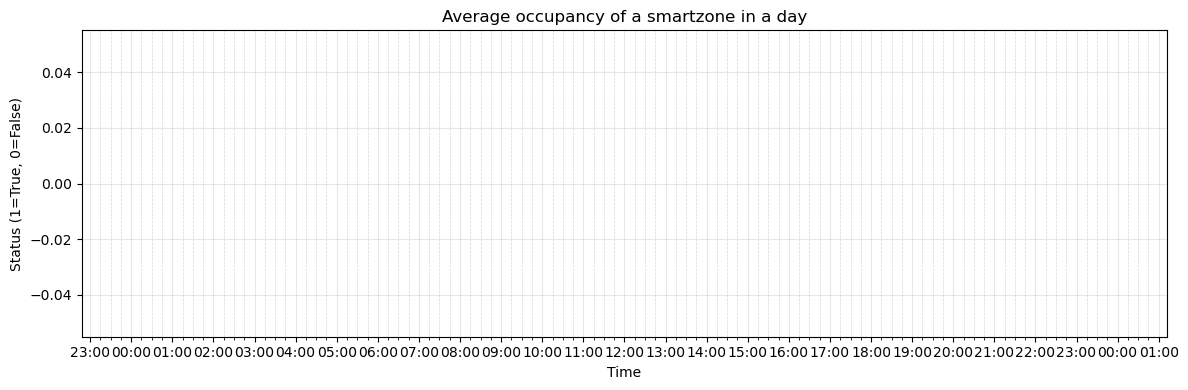

In [574]:
def plot_sensor_status(date, data):
    data = filter_by_date(data, date)
    fig, ax = plt.subplots(1, 1, figsize=(12,4), sharex=True)
    ax.step(data["date"], data["status"].astype(float))
    # Major ticks every hour
    fig.gca().xaxis.set_major_locator(mdates.HourLocator())
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Minor ticks every 15 minutes
    fig.gca().xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
    # Show grid for both major and minor ticks
    ax.grid(which='major', linestyle='-', linewidth=0.8)
    ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_title(f"Average occupancy of a smartzone in a day")
    ax.set_xlabel("Time")
    ax.set_ylabel("Status (1=True, 0=False)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

date = '2024-10-10'
plot_sensor_status(date, data)

Heatmap of the average occupancy in a whole week of the selected smartzone, where the intervals are set to 15 minutes.

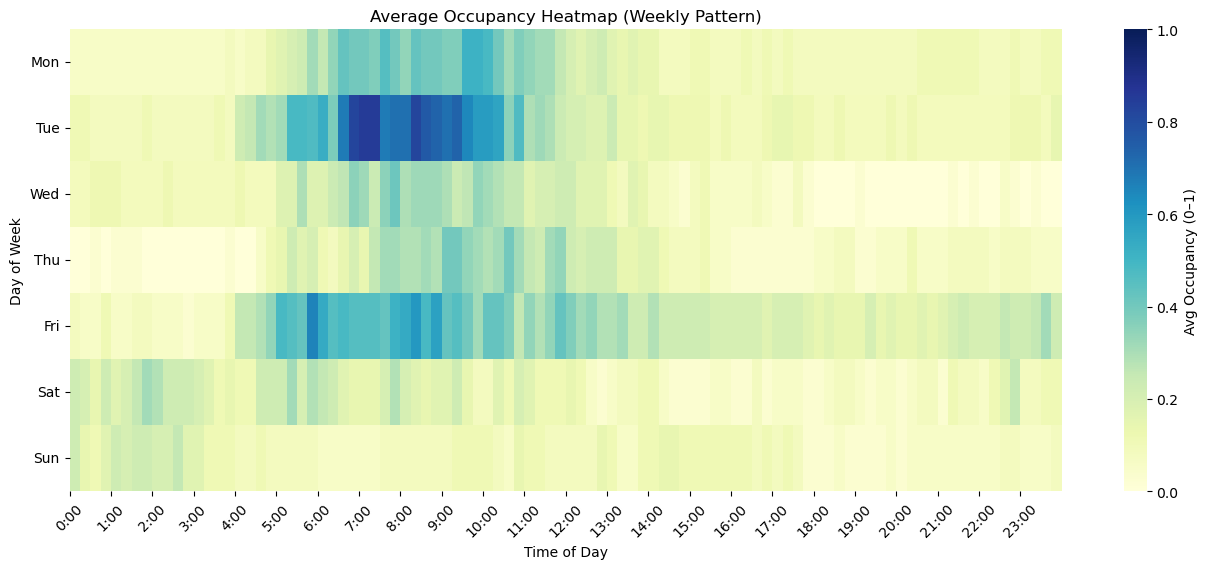

In [575]:
heatmap_data = data
heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek

heatmap_data = heatmap_data.groupby(['day_of_week','slot'])['status'].mean().unstack()
heatmap_data = heatmap_data.astype(float)  # force numeric

plt.figure(figsize=(16,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label':'Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Average Occupancy Heatmap (Weekly Pattern)")
xticks = np.arange(0, 96, 4)
xlabels = [str(i) + ":00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.show()

Heatmap of the occupany of the whole week split up in intervals of 15 minutes, where we broke it down into 3 categories. We made this plot to visualize how it would look like for the users of the Coding the Curbs booking system, so the logistical drivers. Green means that the average is under 30% occupancy, orange means that the occupancy it between 30% and 60% and red means that the average occupancy is higher than 60%.

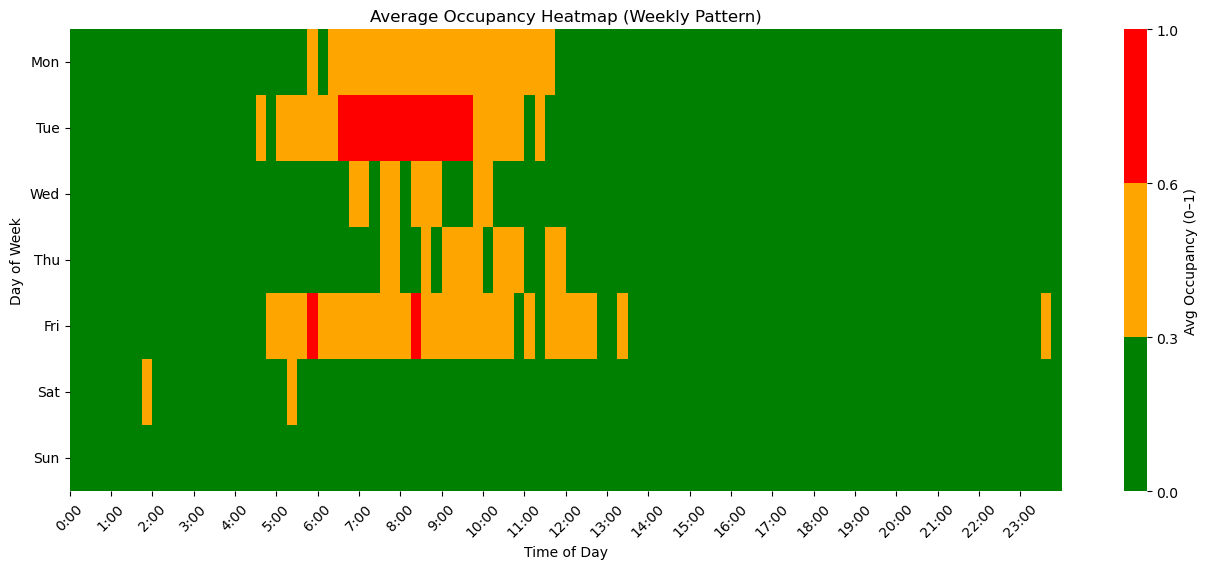

In [576]:
# You can set your own colors here
colors = ["green", "orange", "red"]
bounds = [0, 0.3, 0.6, 1]  # The thresholds of the boundaries
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(16,6))
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    norm=norm,
    vmin=0, vmax=1, 
    cbar_kws={'label': 'Avg Occupancy (0–1)'}
)

plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)

plt.show()

Same 3 color scheme heatmaps, but with different intervals.

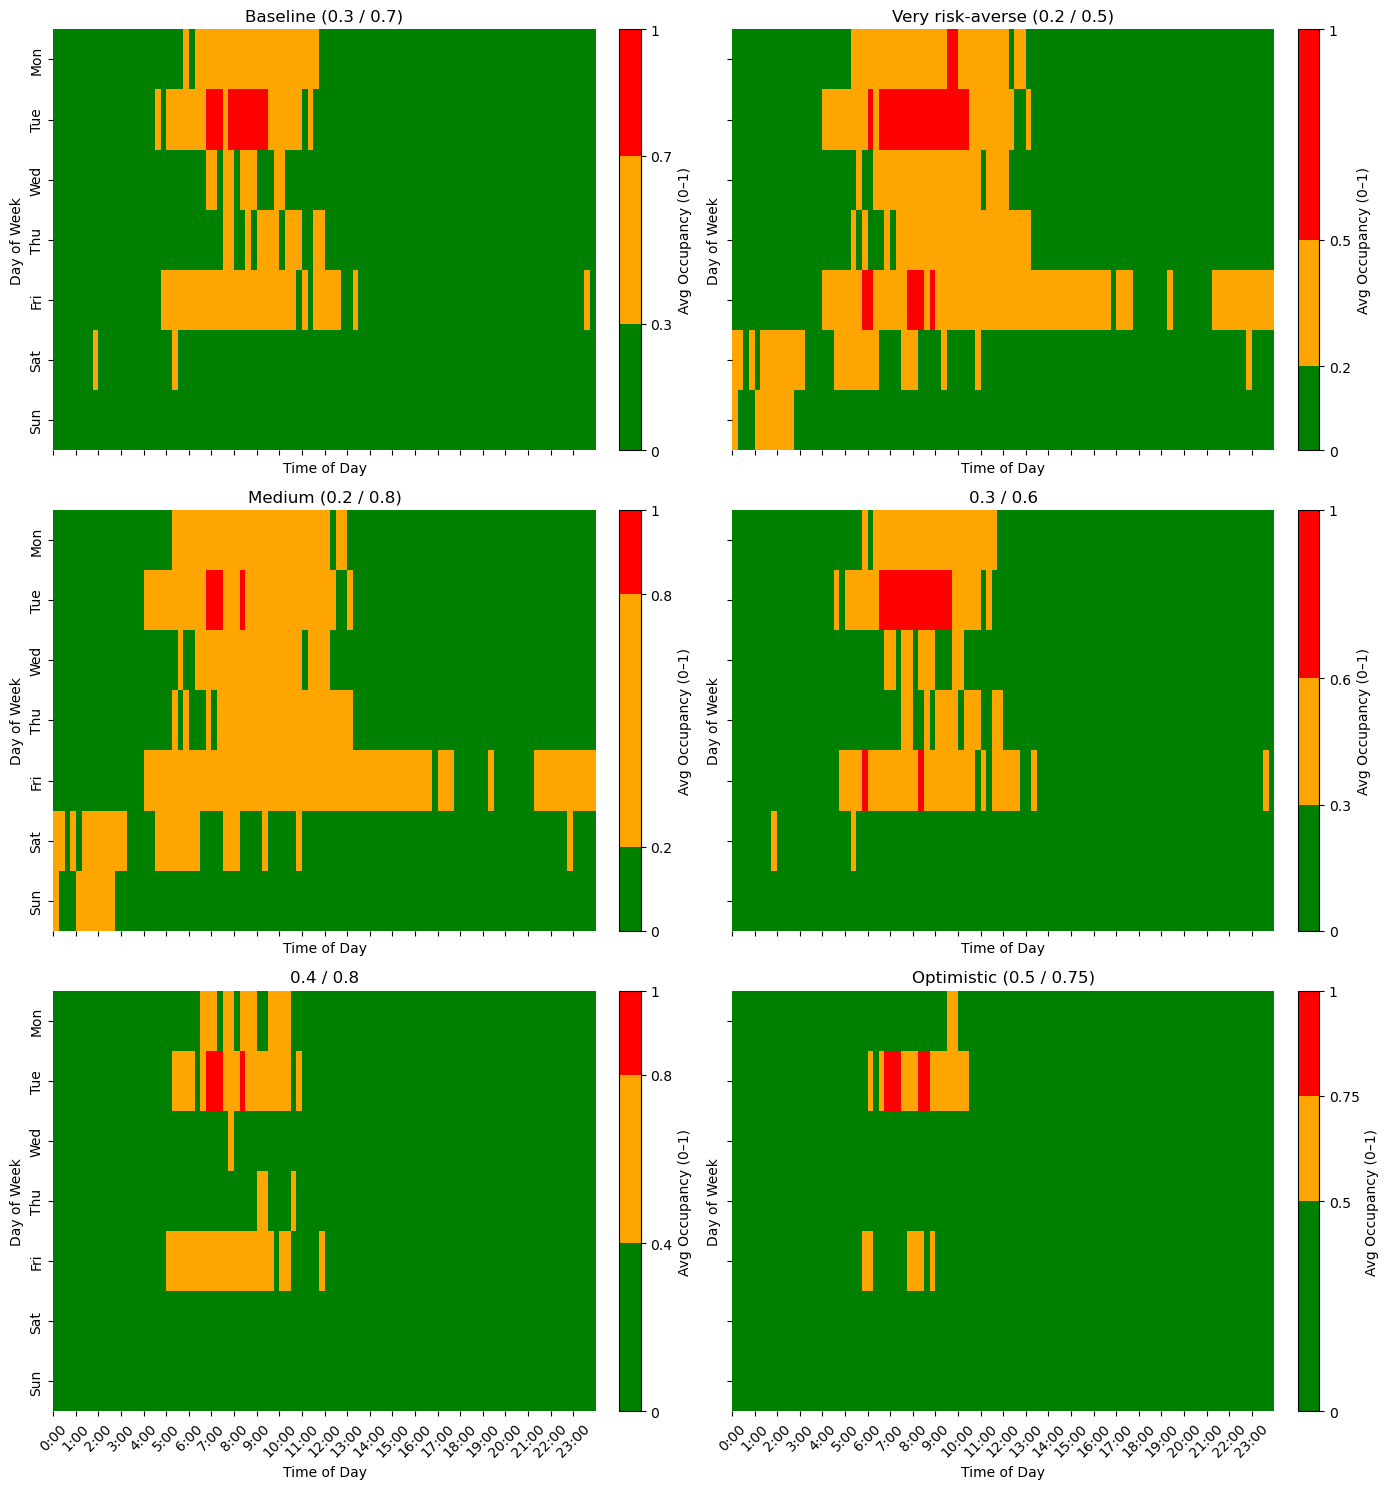

In [577]:
# Here you can set your own colors
colors = ["green", "orange", "red"]

data_plot = heatmap_data.astype(float)
cmap = ListedColormap(colors)

# 6 scenario's + names
boundaries_list = [
    [0.0, 0.3, 0.7, 1.0],   # baseline
    [0.0, 0.2, 0.5, 1.0],   # very risk-averse
    [0.0, 0.2, 0.8, 1.0],   # medium
    [0.0, 0.3, 0.6, 1.0],   # strong around 0.6
    [0.0, 0.4, 0.8, 1.0],   # simpler
    [0.0, 0.5, 0.75, 1.0],  # optimistic
]
scenario_names = [
    "Baseline (0.3 / 0.7)",
    "Very risk-averse (0.2 / 0.5)",
    "Medium (0.2 / 0.8)",
    "0.3 / 0.6",
    "0.4 / 0.8",
    "Optimistic (0.5 / 0.75)",
]

rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), sharex=True, sharey=True, squeeze=False)

for ax, bounds, name in zip(axes.ravel(), boundaries_list, scenario_names):
    norm = BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

    hm = sns.heatmap(
        data_plot,
        cmap=cmap,
        norm=norm,
        vmin=0, vmax=1,       
        ax=ax,
        cbar=False,
        linewidths=0
    )

    cbar = fig.colorbar(
        hm.collections[0],
        ax=ax,
        boundaries=bounds,
        ticks=bounds,                 
        spacing='proportional',       
        fraction=0.046, pad=0.04
    )
    cbar.ax.set_yticklabels([f"{b:g}" for b in bounds])
    cbar.set_label("Avg Occupancy (0–1)")

    ax.set_title(name)
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Day of Week")
    ax.set_xticks(np.arange(0, 96, 4))
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)
    ax.set_yticks(np.arange(0.5, 7.5))
    ax.set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

plt.tight_layout()
plt.show()

We also made plots that show the occupancy throughout the day, but within the same format as google uses. 

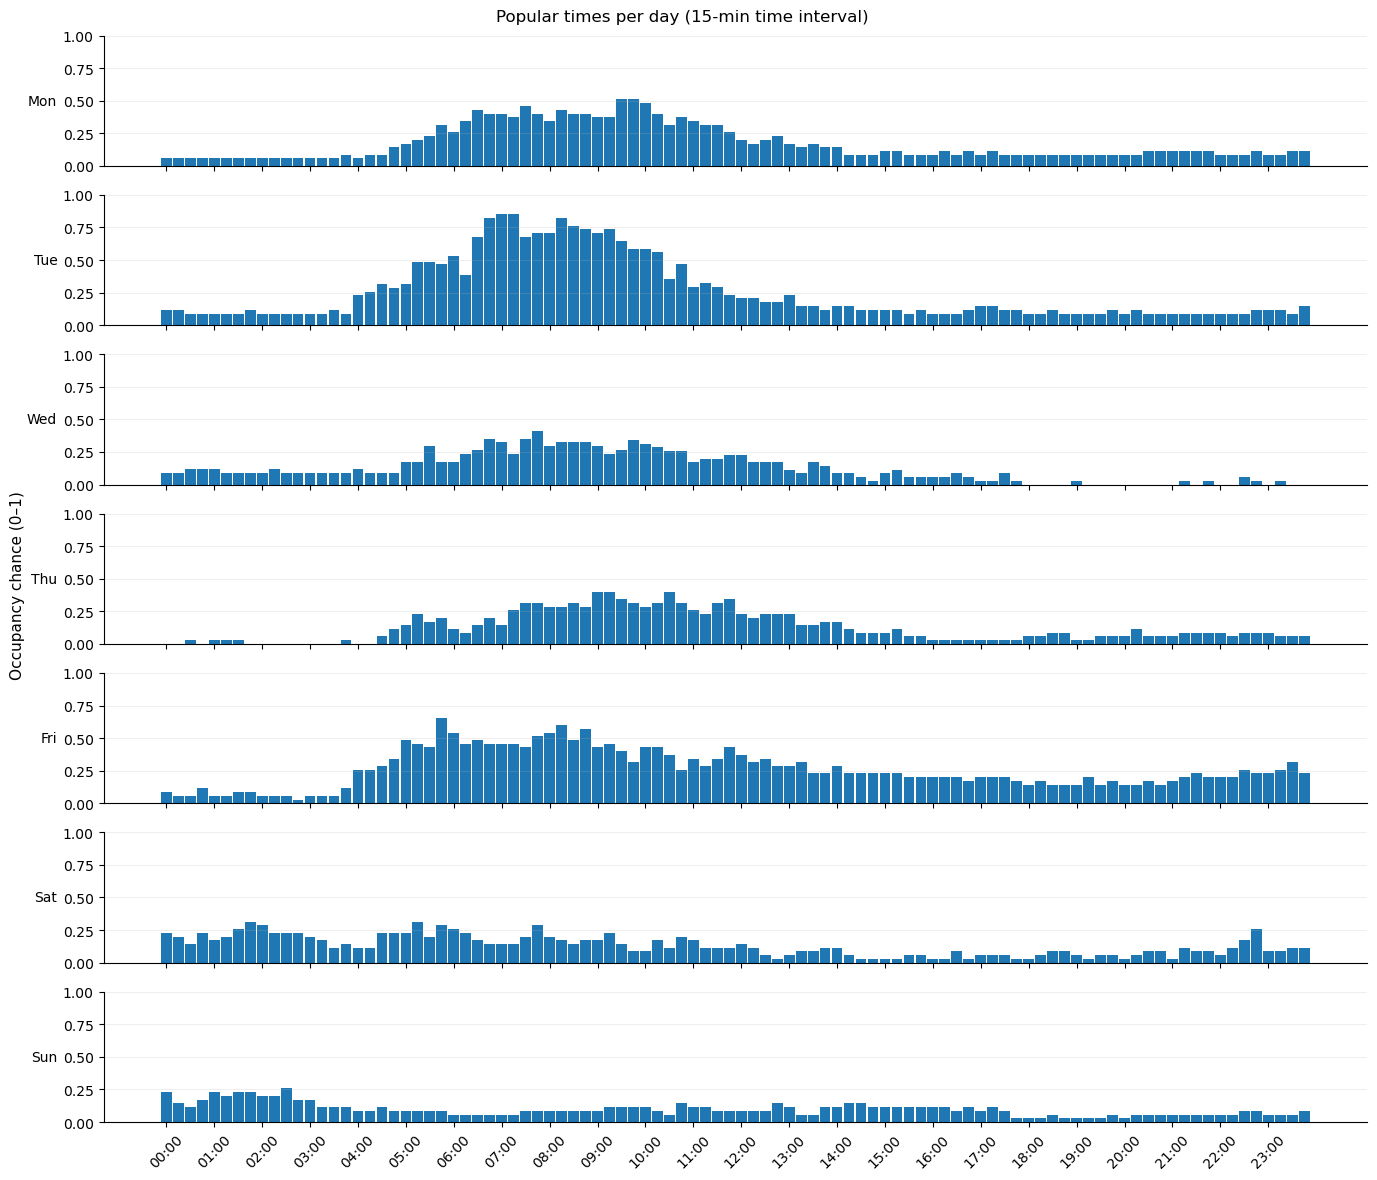

In [578]:
day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

fig, axes = plt.subplots(7, 1, figsize=(14, 12), sharex=True, sharey=True)

for d in range(7):
    ax = axes[d]
    y = heatmap_data.loc[d].values.astype(float)  
    x = np.arange(96)

    ax.bar(x, y, width=0.9)                       
    ax.set_ylim(0, 1)
    ax.set_ylabel(day_names[d], rotation=0, ha="right", va="center")
    ax.grid(axis="y", linewidth=0.5, alpha=0.3)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

hour_ticks = np.arange(0, 96, 4)
hour_labels = [f"{h:02d}:00" for h in range(24)]
axes[-1].set_xticks(hour_ticks)
axes[-1].set_xticklabels(hour_labels, rotation=45)

fig.suptitle("Popular times per day (15-min time interval)")
fig.supylabel("Occupancy chance (0–1)", fontsize=11)
fig.tight_layout()
plt.show()

Lastly, we visualized the data to see of there were yearly patterns. Sadly, the dataset is not of a full year. Which means that we cannot look at yearly patterns. For example, Christmas, Easter, etc. 

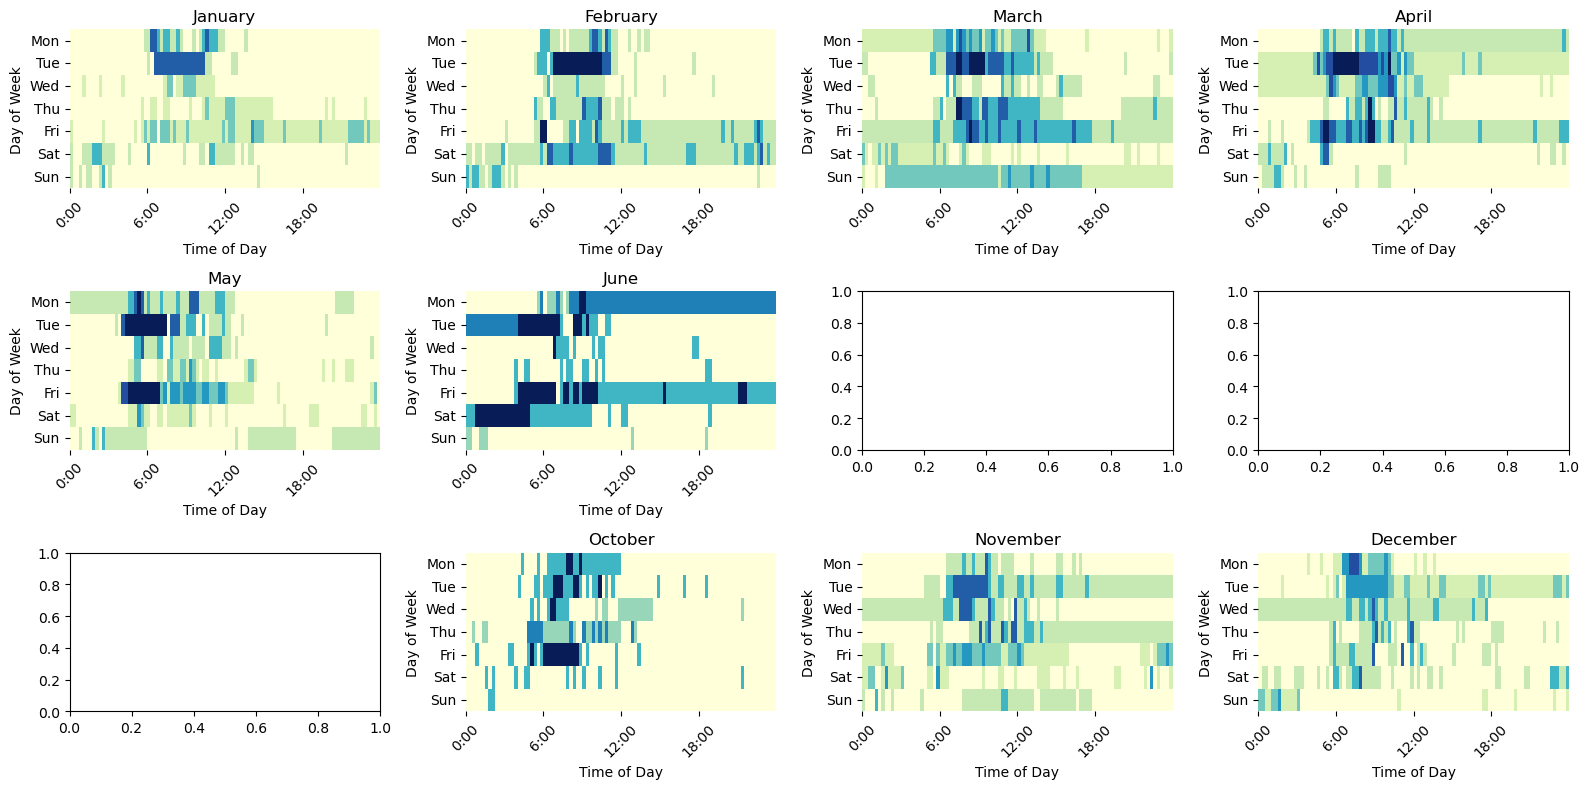

In [579]:
data['month'] = data['date'].dt.month  

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for month in range(1, 13):
    heatmap_data = data[data['month'] == month].copy()

    if heatmap_data.empty:
        continue  

    heatmap_data = heatmap_data.sort_values('date')
    heatmap_data = heatmap_data.drop_duplicates(subset='date', keep='first')
    heatmap_data = (
        heatmap_data.set_index('date')
        .resample('15min')
        .ffill()
        .reset_index()
    )
    heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek
    heatmap_data['slot'] = heatmap_data['date'].dt.hour * 4 + heatmap_data['date'].dt.minute // 15

    heatmap_data = (
        heatmap_data.groupby(['day_of_week', 'slot'])['status']
        .mean()
        .unstack()
        .astype(float)
    )
    
    ax = axes[month - 1]
    sns.heatmap(heatmap_data, cmap="YlGnBu", vmin=0, vmax=1, cbar=False, ax=ax)
    ax.set_title(pd.to_datetime(f'2024-{month:02d}-01').strftime('%B'))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Day of Week")

    xticks = np.arange(0, 96, 24) 
    xlabels = [f"{i}:00" for i in range(0, 24, 6)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_yticks(np.arange(0.5, 7.5))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)

plt.tight_layout()
plt.show()

## Feature engineering
Preparing the data to use for the XGBoost model. We make some extra values namely:

- 15-min timeslots, changes the dataset so we have a new dataset for all of the 15 min intervals inbetween the first timeslot we have in the dataset, to the last date. 
- Rolling windows, for window sizes of 1 hour, 3 hours, 6 hours, 1 day and 1 week. You can add extra windows, but don't forget to add them to the used features later in the notebook.
- Lag features, how far back should the model look. Meaning a lag of 1 looks at the 15 min interval before. A lag of 2 looks at the interval 2 back, 12 looks at the slot 3 hours back, 96 looks at the slot one day back and 672 looks at the same timeslot but one week ago.
- Is weekend, this is 1 of it is Saturday or Sunday and 0 otherwise. 




In [580]:
# Rolling features
rolling_windows = {
    '1h': 4,
    '3h': 12, 
    '6h': 24, 
    '1d': 96, 
    '1w': 672
}

# Lag features
lags = [1, 2, 3, 4, 12, 24, 96, 672]

def load_data_for_zone(smartzone, dataset):
    # Copy original dataset
    data = dataset.copy()
    data = data[data['location name'] == smartzone]

    # Ensure integer status
    data['status'] = data['status'].astype(float)

    # Regularize timeseries
    data = data.sort_values('date')
    data = data.drop_duplicates(subset='date', keep='first')
    data = data.set_index('date').resample('15min').ffill().reset_index()

    # Time features
    data['day_of_week'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month
    data['day_of_month'] = data['date'].dt.day
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    data['slot'] = data['date'].dt.hour * 4 + data['date'].dt.minute // 15
    data['time_of_day'] = data['slot'] / 96
    data['dow_slot'] = data['day_of_week'].astype(str) + "_" + data['slot'].astype(str)

    for lag in lags:
        data[f'status_lag_{lag}'] = data['status'].shift(lag)

    for name, window in rolling_windows.items():
        data[f'status_roll_mean_{name}'] = data['status'].rolling(window).mean().shift(1)
        data[f'status_roll_max_{name}'] = data['status'].rolling(window).max().shift(1)
        data[f'status_roll_min_{name}'] = data['status'].rolling(window).min().shift(1)
        data[f'status_roll_sum_{name}'] = data['status'].rolling(window).sum().shift(1)

    # Drop NaNs after lag/rolling
    data = data.dropna().reset_index(drop=True)

    return data

data_with_features = load_data_for_zone(smartzone, dataset)


## Model training
Selecting which features to use. In case you added extra features to the dataset, you should add them in here as well. Otherwise the model won't consider them. 

In [581]:
features = [
    'day_of_week','month','day_of_month','is_weekend','time_of_day','dow_slot',
    'status_lag_1','status_lag_2','status_lag_3','status_lag_4',
    'status_lag_12','status_lag_24','status_lag_96', 'status_lag_672',
    'status_roll_mean_1h','status_roll_max_1h','status_roll_min_1h','status_roll_sum_1h',
    'status_roll_mean_3h','status_roll_max_3h','status_roll_min_3h','status_roll_sum_3h',
    'status_roll_mean_6h','status_roll_max_6h','status_roll_min_6h','status_roll_sum_6h',
    'status_roll_mean_1d','status_roll_max_1d','status_roll_min_1d','status_roll_sum_1d',
    'status_roll_mean_1w','status_roll_max_1w','status_roll_min_1w','status_roll_sum_1w'
]

## Model selection
Like already stated we use the XGBoost model as a regression. 

In this part we create the model, split the dataset into train and test set. Where the first 80% of data, sorted on date, is for the train set and the last 20% for the testset. 

In [582]:
def get_model(data_set):
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        enable_categorical=True,
        random_state=42,
    )
    
    X = data_set[features].copy()
    X['dow_slot'] = X['dow_slot'].astype('category')

    y = data_set['status'].astype(float)  # regression target (probability 0–1)

    # Train/test split (last 20% is test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model.fit(X_train, y_train)

    # Predictions on test set
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred,0,1)

    return model, X, X_train, X_test, y_pred, y_test


model, X, X_train, X_test, y_pred, y_test = get_model(data_with_features)


# Feature Selection Techniques
Some plots that show the importance of the features and checking if the features are contributing enough to keep in the model.

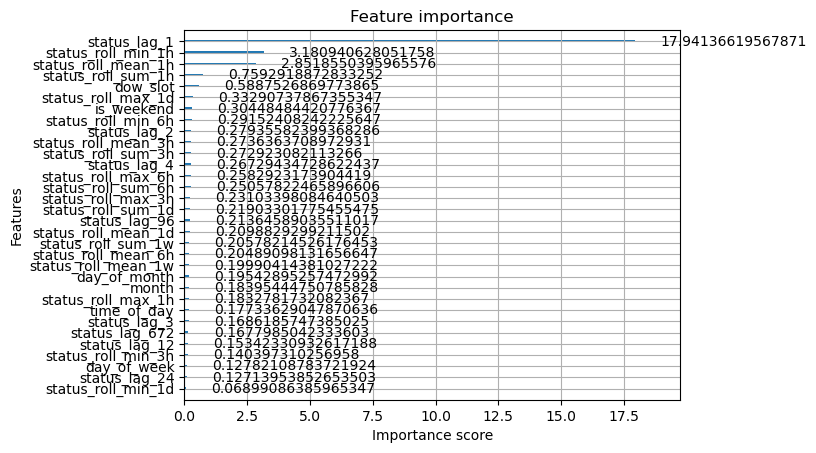

In [583]:
xgb.plot_importance(model, importance_type='gain', max_num_features=35)
plt.show()

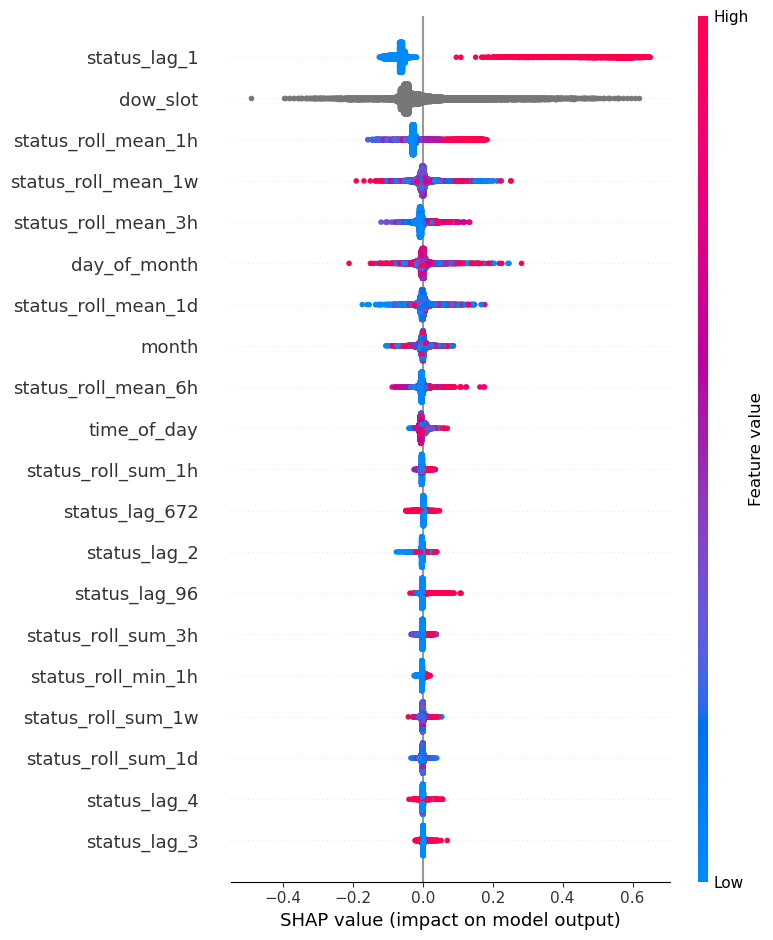

In [584]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

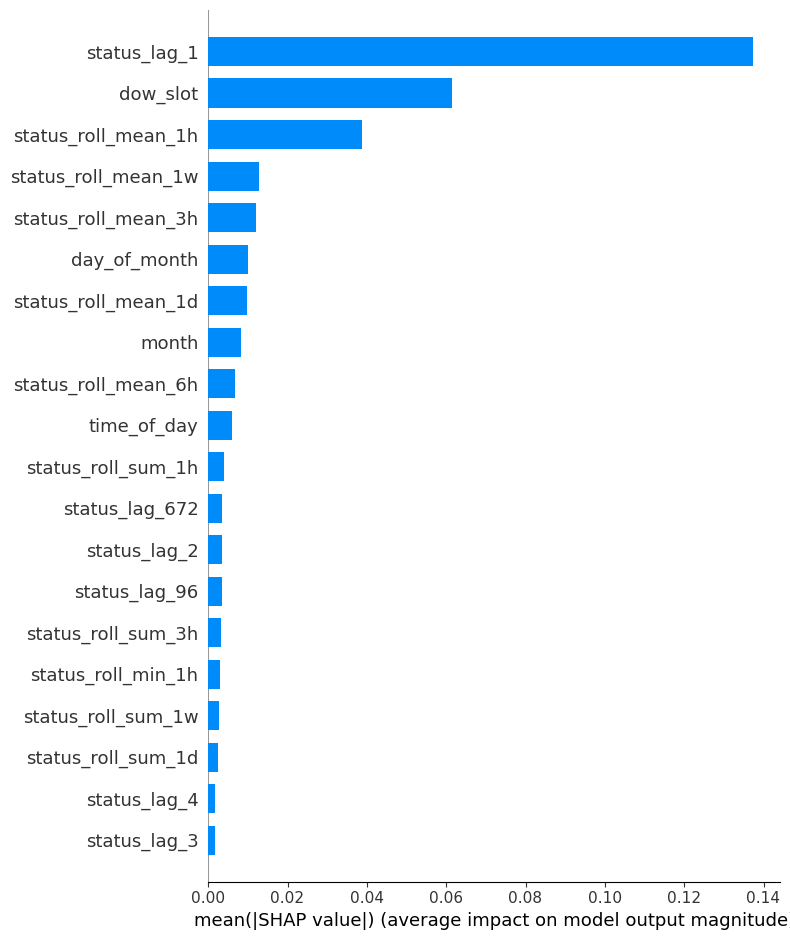

In [585]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


## Model evaluation
evaluating the model using the ROC AUC score, RMSE and MAE values. 

We want the ROC AUC score to be as close to 1 as possible and the RMSE and MAE to be as close to 0 as possible.

In [586]:
# Evaluate
def evaluation(y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return roc_auc, rmse, mae

roc_auc, rmse, mae = evaluation(y_test, y_pred)

print(f"Tests: ROC AUC: {roc_auc:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} ")

Tests: ROC AUC: 0.9193 | RMSE: 0.2536 | MAE: 0.1179 


## Results visualization
Heatmap of the test set data, showing the average occupancy of the spot in 15-min intervals in the specific smartzone.

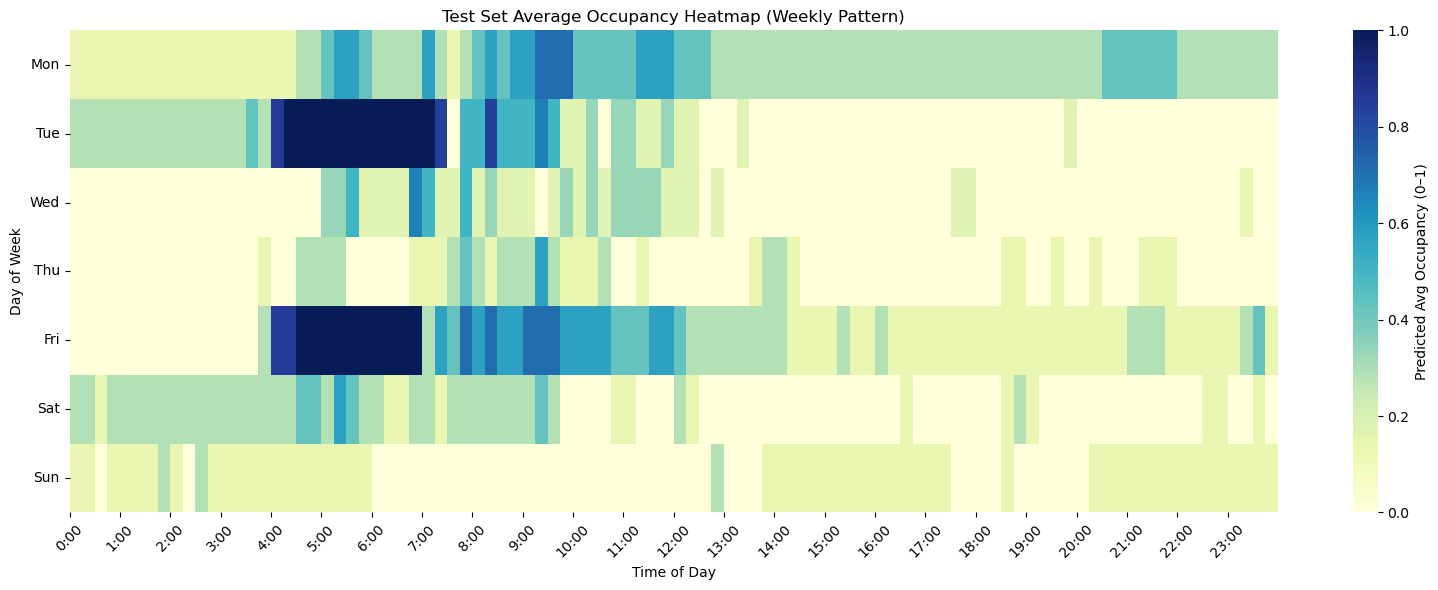

In [587]:
X_test["occupancy"] = y_test

X_test['slot'] = X_test['dow_slot'].astype(str).str.split("_").str[1].astype(int)

heatmap_pred = (
    X_test.groupby(["day_of_week", "slot"])["occupancy"]
    .mean()
    .unstack()
)

# Plot
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_pred, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label': 'Predicted Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Test Set Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Heatmap of the predicted data, showing the predicted occupancy of the spot in the 15-min slots in Neude. We want this heatmap to look like the plot above, so the average occupancy heatmap of the test set. 

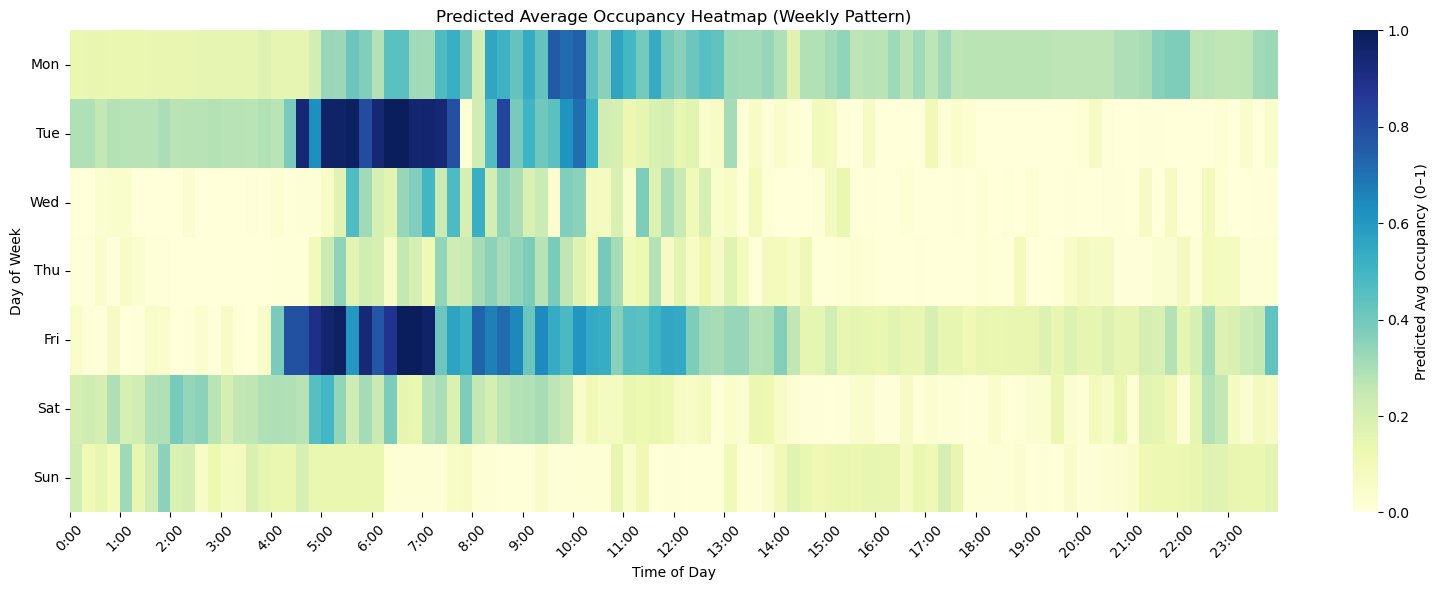

In [588]:

data_pred = X_test.copy()
data_pred["prediction"] = y_pred

data_pred['slot'] = data_pred['dow_slot'].astype(str).str.split("_").str[1].astype(int)

heatmap_pred = (
    data_pred.groupby(["day_of_week", "slot"])["prediction"]
    .mean()
    .unstack()
)

# Plot
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_pred, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label': 'Predicted Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Predicted Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Lineplot of the predicted occupancy against the true occupancy in the test set for average occupancy in the selected smartzone.

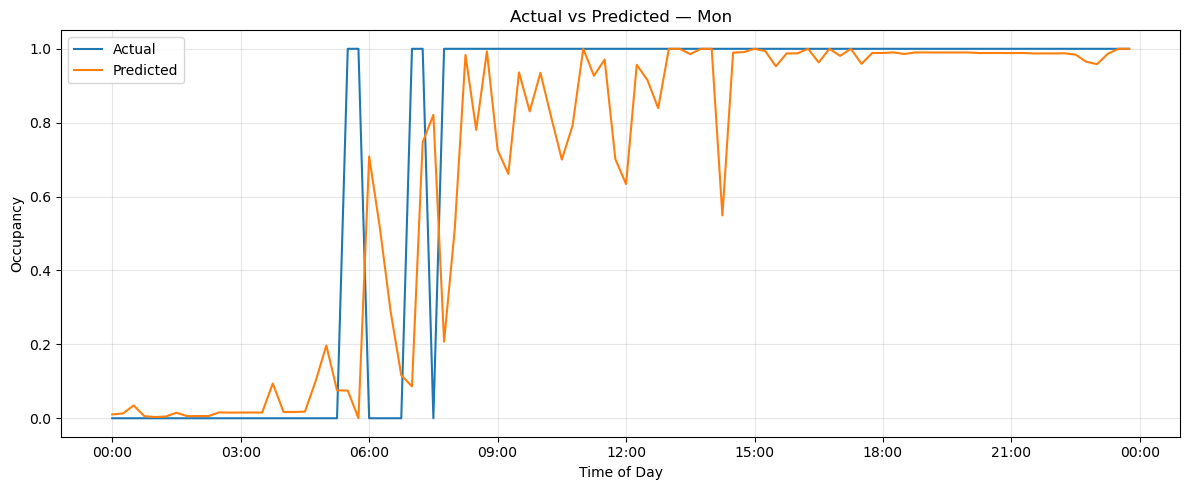

In [589]:
df = X_test.copy()
df["y_true"] = y_test
df["y_pred"] = y_pred

df[["day_of_week","slot"]] = (
    df["dow_slot"].astype(str).str.split("_", expand=True).astype(int)
)

dow = 0
dom = 16
m = 6

day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
title_day = day_names[dow]

day_df = (df[(df["day_of_week"] == dow) & (df["day_of_month"] == dom) & (df["month"] == m)]
          .groupby("slot")[["y_true","y_pred"]]
          .mean()
          .reset_index()
          .sort_values("slot"))

time_base = pd.to_datetime("2000-01-01")  # arbitraire datum
day_df["time"] = time_base + pd.to_timedelta(day_df["slot"] * 15, unit="m")

plt.figure(figsize=(12,5))
plt.plot(day_df["time"], day_df["y_true"], label="Actual")
plt.plot(day_df["time"], day_df["y_pred"], label="Predicted")
plt.title(f"Actual vs Predicted — {title_day}")
plt.xlabel("Time of Day")
plt.ylabel("Occupancy")
plt.legend()
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.tight_layout()
plt.show()

## Forecasting for Dashboard
Here we made a forcasting for a week in advance so that we can later use this in the dashboard. 

In [590]:
def get_forecasting_df(X, model, data):
    dow_slot_cats = X['dow_slot'].cat.categories  

    max_lag = max(lags)
    hist = data.copy().reset_index(drop=True)
    hist_needed = hist.tail(max(672, max_lag) )   

    hist_status = hist_needed['status'].to_numpy()
    start_ts = hist_needed['date'].iloc[-1]

    H = 96 * 7  # 1 week in advance in 15-min slots
    pred_ts, pred_vals = [], []

    for k in range(0, H):
        ts   = start_ts + pd.Timedelta(minutes=15 * k)
        slot = ts.hour * 4 + ts.minute // 15
        dow  = ts.dayofweek

        feats = {
            'day_of_week': dow,
            'month': ts.month,
            'day_of_month': ts.day,
            'is_weekend': int(dow >= 5),
            'time_of_day': slot / 96,
            'dow_slot': f"{dow}_{slot}",
        }

        for L in lags:
            idx = -(L - k) - 1
            if idx < -len(hist_status):
                feats[f'status_lag_{L}'] = np.nan
            else:
                feats[f'status_lag_{L}'] = float(hist_status[idx])

        for name in rolling_windows.keys():
            feats[f'status_roll_mean_{name}'] = np.nan
            feats[f'status_roll_max_{name}']  = np.nan
            feats[f'status_roll_min_{name}']  = np.nan
            feats[f'status_roll_sum_{name}']  = np.nan

        Xp = pd.DataFrame([feats])[features]
        Xp['dow_slot'] = pd.Categorical(Xp['dow_slot'], categories=dow_slot_cats)

        p = model.predict(Xp)[0]

        pred_ts.append(ts)
        pred_vals.append(np.clip(p, 0, 1))

    forecast_df = pd.DataFrame({'date': pred_ts, 'status_pred': pred_vals})
    return forecast_df

forecast_df = get_forecasting_df(X, model, data_with_features)

This creates the heatmap of the forecasted data that can be shown in the dashboard.

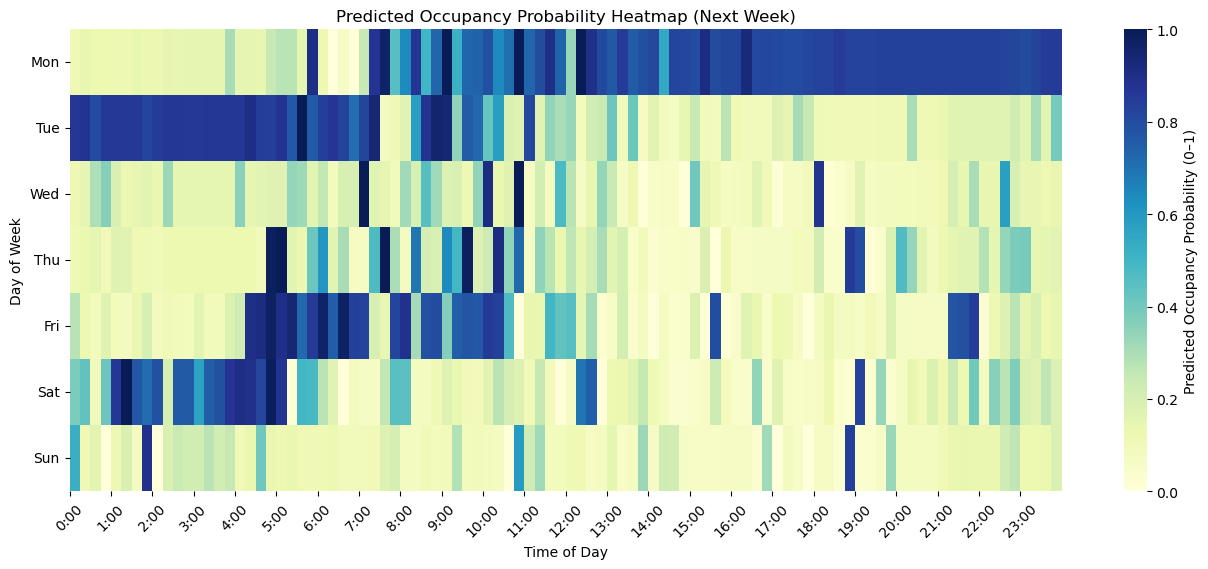

In [591]:
def get_forecast_heatmap(forecast_df):
    forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
    forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

    heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['status_pred'].mean().unstack()

    plt.figure(figsize=(16,6))
    sns.heatmap(heatmap_matrix, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label':'Predicted Occupancy Probability (0–1)'})
    plt.xlabel("Time of Day")
    plt.ylabel("Day of Week")
    plt.title("Predicted Occupancy Probability Heatmap (Next Week)")
    xticks = np.arange(0, 96, 4)
    xlabels = [str(i)+":00" for i in range(24)]
    plt.xticks(xticks, xlabels, rotation=45)
    plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
    plt.show()

get_forecast_heatmap(forecast_df)

The forecasted occupancy of the smartzone in a heatmap, but in 3 colors.

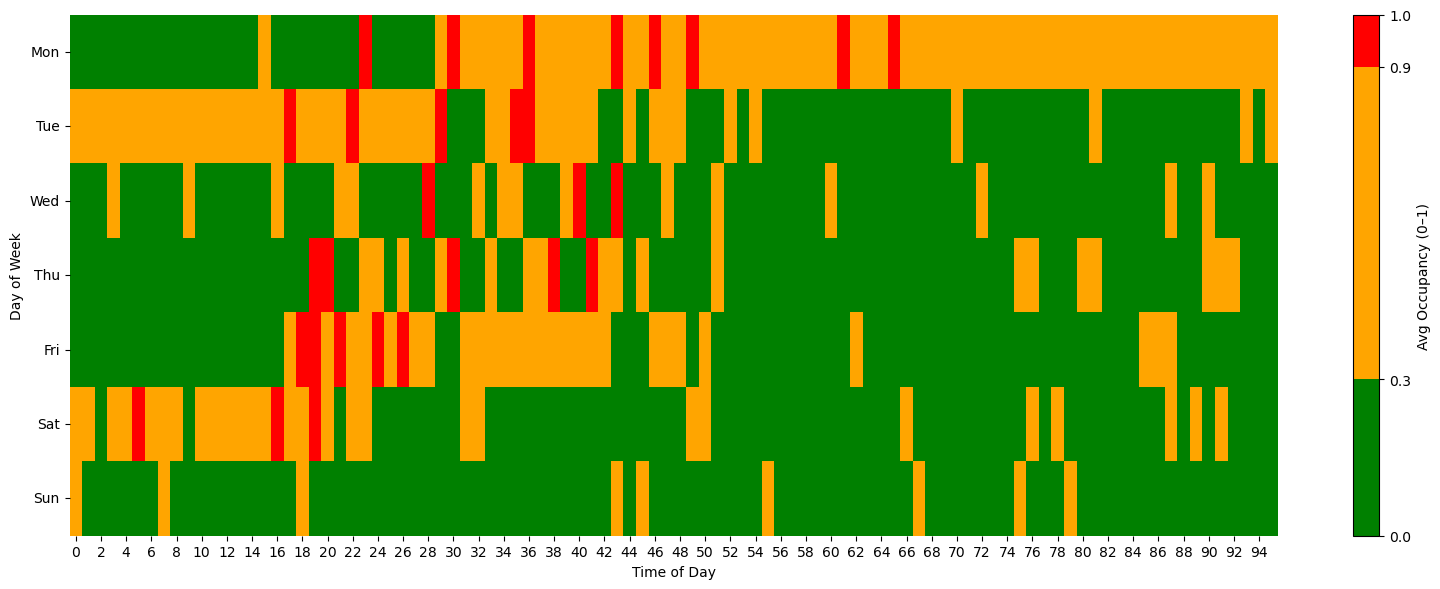

In [592]:
colors = ["green", "orange", "red"]
bounds = [0, 0.3, 0.9, 1]  
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['status_pred'].mean().unstack()

fig, ax = plt.subplots(figsize=(16,6))
hm = sns.heatmap(
    heatmap_matrix,
    cmap=cmap,
    norm=norm,
    vmin = 0, vmax = 1,
    ax = ax,
    cbar = False
)

cbar = fig.colorbar(
    hm.collections[0],
    ax=ax,
    boundaries=bounds,
    ticks=bounds,                
    spacing='proportional'       
)
cbar.set_label("Avg Occupancy (0–1)")

cbar.ax.set_yticklabels([f"{b:.1f}" for b in bounds])
ax.set_xlabel("Time of Day")
ax.set_ylabel("Day of Week")
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Boxplot of the forcasted occupancy of the smartzone. 

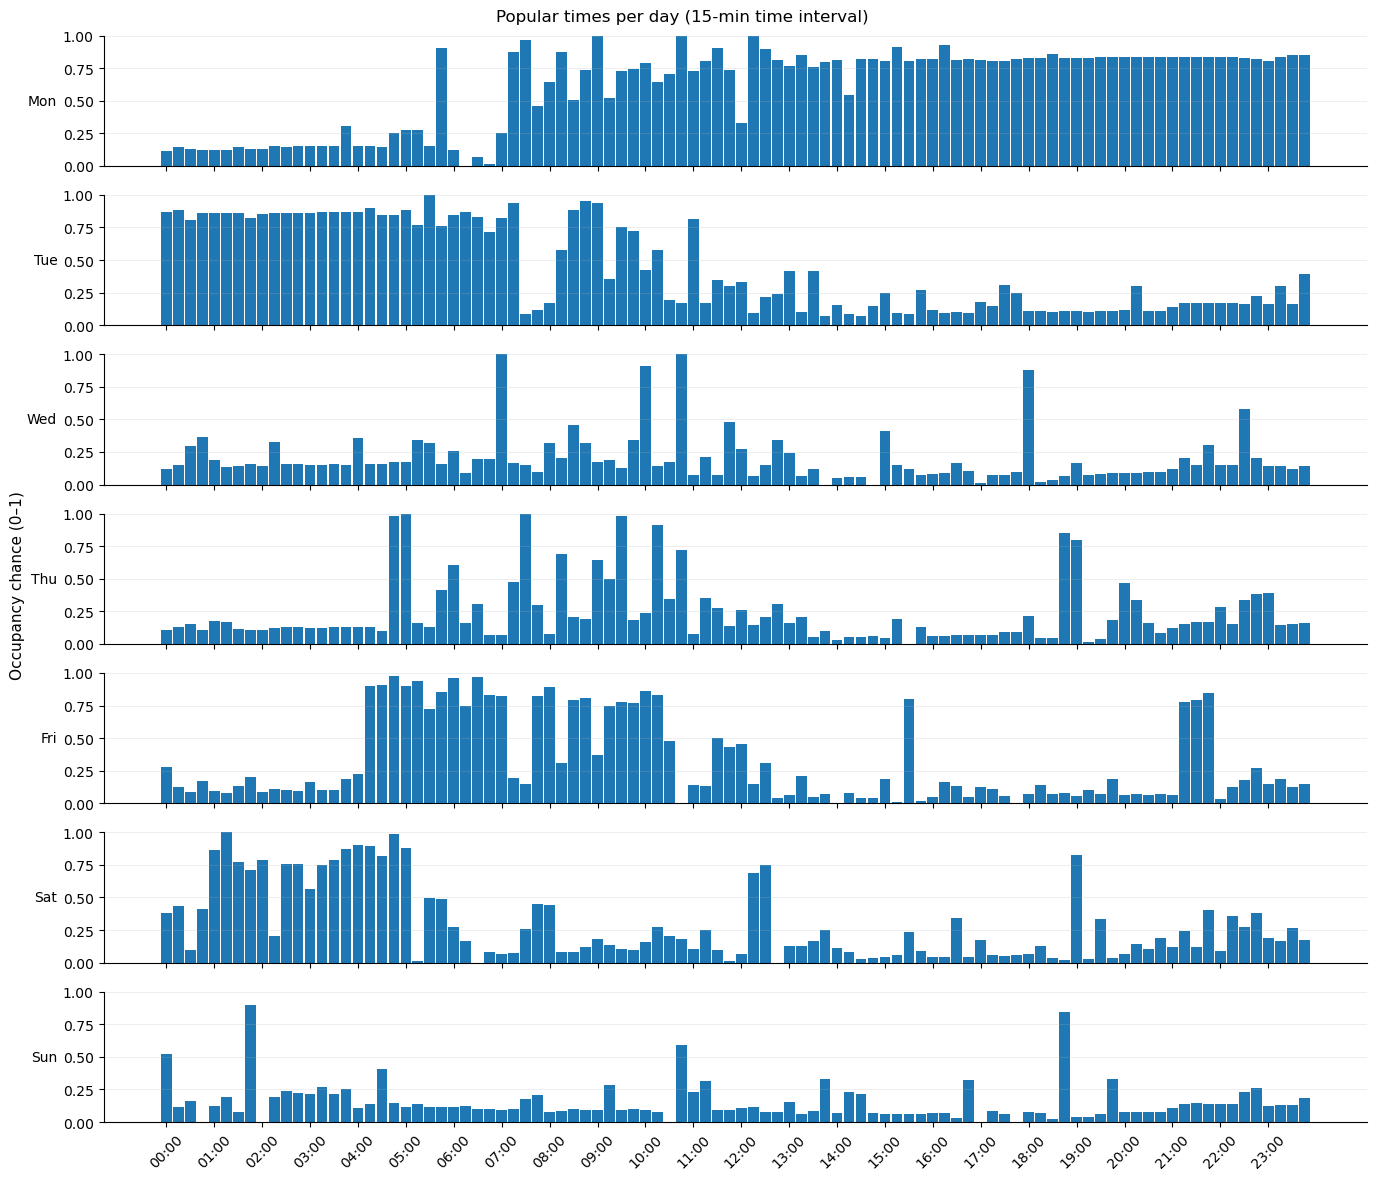

In [593]:
day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

fig, axes = plt.subplots(7, 1, figsize=(14, 12), sharex=True, sharey=True)

for d in range(7):
    ax = axes[d]
    y = heatmap_matrix.loc[d].values.astype(float)   
    x = np.arange(96)

    ax.bar(x, y, width=0.9)                        
    ax.set_ylim(0, 1)
    ax.set_ylabel(day_names[d], rotation=0, ha="right", va="center")
    ax.grid(axis="y", linewidth=0.5, alpha=0.3)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

hour_ticks = np.arange(0, 96, 4)
hour_labels = [f"{h:02d}:00" for h in range(24)]
axes[-1].set_xticks(hour_ticks)
axes[-1].set_xticklabels(hour_labels, rotation=45)

fig.suptitle("Popular times per day (15-min time interval)")
fig.supylabel("Occupancy chance (0–1)", fontsize=11)
fig.tight_layout()
plt.show()

# Dashboard Integration

This is a low quality version of the integration of our forecasting model of the smartzone into the dashboard of Coding the Curbs their dashboard. In the presentation we show a higher quality version.

We can select the smartzone in this dashboard by using the dropdown menu. After selecting the smartzone, the model starts training and after training and evaluating, it shows the evaluation. Then it starts forcasting for a week in advance and it shows the results of the forecast in a heatmap in the dashboard. 

In [594]:
smartzone_dropdown = widgets.Dropdown(
    options=['Neude', 'Lange Viestraat', 'Stadhuisplein', 'Domplein', "'t Wed", 'Beurskwartier'],
    description='Smartzone:',
)

output = widgets.Output()

def on_zone_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output()
            zone_widget = change['new']
            data_widget = load_data_for_zone(zone_widget, dataset)
            model_widget, Xt, X_train, X_test, y_pred, y_test = get_model(data_widget)
            roc_auc, rmse, mae = evaluation(y_test, y_pred)

            print(f"Model Evaluation on Smartzone:")
            print(f"  ROC-AUC: {roc_auc:.3f}")
            print(f"  RMSE:    {rmse:.3f}")
            print(f"  MAE:     {mae:.3f}\n")

            preds = get_forecasting_df(Xt, model_widget, data_widget)
            get_forecast_heatmap(preds)

smartzone_dropdown.observe(on_zone_change)
display(smartzone_dropdown, output)

Dropdown(description='Smartzone:', options=('Neude', 'Lange Viestraat', 'Stadhuisplein', 'Domplein', "'t Wed",…

Output()